# Why use Polynomial Regession Bands?
Polynomial regression bands are a type of volatility channel indicator that plots two standard deviations away from a polynomial regression line. The polynomial regression line is calculated by fitting a polynomial equation to the closing prices of a security over a specific time period. The resulting line represents the underlying trend of the security. The two standard deviations are then plotted above and below the regression line, creating a band that moves with the trend.

- Breakouts: When the price breaks above the upper band or below the lower band, it can be a sign of a significant move, and traders may consider entering a long position in the case of an upside breakout or a short position in the case of a downside breakout.
- Mean reversion: When the price touches or approaches the upper or lower band, it can be a sign that the price is stretched and may revert to the mean, which is the regression line. Traders may consider entering a short position if the price is near the upper band or a long position if the price is near the lower band.
- Trend identification: The polynomial regression bands can help identify the overall trend of a security. If the price is trading above the regression line, it can indicate an uptrend, while trading below the line can indicate a downtrend.


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import lu, solve_triangular
import yfinance as yf  # To fetch financial data


In [11]:
# Fetching real-time data for the S&P 500 E-mini Futures, using an equivalent ETF 'SPY'
data = yf.download('SPY', period='1mo', interval='1h')
# Assuming 'Close' price is used for the analysis
close_prices = data['Close']


[*********************100%%**********************]  1 of 1 completed


In [12]:
# Super Smoother Filter function
def super_smoother(series, period):
    # Constants for the filter calculation
    a1 = np.exp(-1.414 * np.pi / period)
    b1 = 2 * a1 * np.cos(1.414 * np.pi / period)
    c2 = b1
    c3 = -a1 * a1
    c1 = 1 - c2 - c3

    # Preallocate the output series with the same initial value as input
    filtered_series = np.full_like(series, series.iloc[0])

    # Apply the filter to the series
    for i in range(2, len(series)):
        filtered_series[i] = c1 * series.iloc[i] + c2 * filtered_series[i - 1] + c3 * filtered_series[i - 2]

    return pd.Series(filtered_series, index=series.index)

# Applying the Super Smoother Filter to the closing prices
filtered_close_prices = super_smoother(close_prices, period=10)


In [13]:
# Number of periods and order of the polynomial regression
n_periods = 100
order = 2

# X values are simply the index of the period
x_vals = np.arange(1, n_periods + 1)

# Y values are the last 'n' filtered close prices
y_vals = filtered_close_prices[-n_periods:]


In [14]:
# Create the Vandermonde matrix for X
X = np.vander(x_vals, N=order + 1, increasing=True)

# Perform LU decomposition on the transpose of X to get a square matrix for decomposition
P, L, U = lu(X.T @ X)

# Solve the linear system for the coefficients using the transpose of X
y = solve_triangular(L, P.T @ (X.T @ y_vals), lower=True)
coefs = solve_triangular(U, y)

# Calculate the regression values
regression_values = X @ coefs


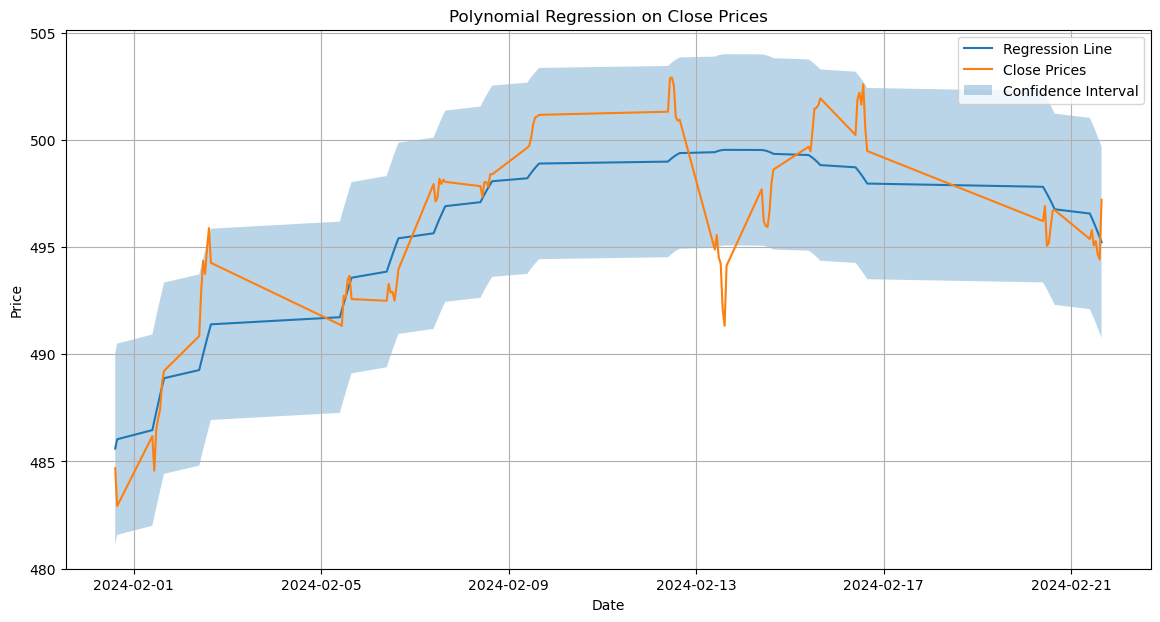

In [15]:
# Calculate the regression values
regression_values = X @ coefs

# Plot the regression line and the close prices
plt.figure(figsize=(14, 7))
plt.plot(close_prices.index[-n_periods:], regression_values, label='Regression Line')
plt.plot(close_prices.index[-n_periods:], close_prices[-n_periods:], label='Close Prices')
plt.fill_between(close_prices.index[-n_periods:], regression_values - np.std(y_vals), regression_values + np.std(y_vals), alpha=0.3, label='Confidence Interval')

# Customize the plot with a grid, legend, and labels
plt.grid(True)
plt.legend()
plt.title('Polynomial Regression on Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


In this example, we see the close revert back to the regression rather sharply after the it broke out below the lower band.